 * get tweets
 * get extended twitter text
 * clean / all lowercase
 * sentiment analysis through Textblob and possibly other
 * find regions tweeted from (map)  -- no coordinates; do count and histogram  --not worthwhile
 * remove stop words
 * lemmetize
 * word cloud 
 * histograms word/username
 **** create own classification of sentiment

In [111]:
#!pip install tweepy
#!pip install textblob
#!pip install vaderSentiment
#!pip install nltk
#!pip install pickle
import pickle
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
#!pip install stanfordcorenlp

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kgray\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kgray\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [107]:
import re
import os
import tweepy as tw
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
from nltk.tokenize import WordPunctTokenizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from stanfordcorenlp import StanfordCoreNLP
import json, string
from nltk.stem import WordNetLemmatizer

In [3]:
consumer_key= 'zccoBXZpbQ89WbzwqjpQkxZma'
consumer_secret= 'lafhvgJ4IFPypeGE85OMFaJbQWYimE5AfT8obw7cpIObDOGcUm'
access_token= '1190842096464220160-qwm7GTPyOKuYxOqhefRi2BD3P9K2V4'
access_token_secret= 'rn9JtEQia4quwZDvLM13lVwexrozBZUCPYjWTvgcN3Smy'

In [4]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [5]:
# Define the search term and the date_since date as variables
search_words = "cardi b"
date_since = "2019-10-01"

In [6]:
#Retweets were removed because it kept being the same messages retweeted, not original ideas
#It does have meaning if retweeted but lazy way of expressing thoughts
new_search = search_words + " -truncated:false" + " -filter:retweets"
new_search

'cardi b -truncated:false -filter:retweets'

In [7]:
tweets = tw.Cursor(api.search, 
                           q=new_search,
                           lang="en",
                           since=date_since).items(5000)

all_tweets = [[tweet.user.screen_name, tweet.user.location, tweet.coordinates, tweet.text] for tweet in tweets]
all_tweets

[['hits923atl',
  '',
  None,
  'DJ Khaled feat. Cardi B &amp; 21 Savage - Wish Wish (Clean)'],
 ['AfahyeJ',
  'Ghana',
  None,
  'When Twitter was \nChampagne pope\nKuseimaametwe \nAisha \nJeojina \nKobby shaggy\nQuarm \nElla \nCardi b \nRihanna \n\nNow ne… https://t.co/odSZtQwNhY'],
 ['Tambae',
  'Randburg',
  None,
  'BEST COLLABO\n\nAri Lennox – “Shea Butter Baby” FT J. Cole\n\nBeyoncé – “Brown Skin Girl” FT Saint Jhn Wizkid &amp; BIC\n\nCa… https://t.co/HMADFjS8gg'],
 ['JAMZ4031', '', None, 'Bruno Mars ft Cardi B - Finesse (Remix) (Clean)'],
 ['mehjabinshahed',
  'Bangladesh',
  None,
  'When Cardi B said \n“It’s gonna hurt me to hate you, \nBut loving you is worse”\n\nthat hit me. https://t.co/LLPYLol9wV'],
 ['Radi0_Raheim',
  'MPI Yonkers',
  None,
  "I also hope 69 presents the evidence needed in court for the feds to lock up Cardi B, she's acts absolutely diaboli… https://t.co/SirqeZnw7m"],
 ['_blaseT',
  'det✈️atl',
  None,
  'cardi b won “rhythm and bars” over 21 and j cole?

In [8]:
all_tweets[0]

['hits923atl',
 '',
 None,
 'DJ Khaled feat. Cardi B &amp; 21 Savage - Wish Wish (Clean)']

In [9]:
tweets = pd.DataFrame(data=all_tweets, 
                    columns=['user', "location","coordinates","text",])
tweets.head()

,user,location,coordinates,text
0,hits923atl,,None,DJ Khaled feat. Cardi B &amp; 21 Savage - Wish...
1,AfahyeJ,Ghana,None,When Twitter was \nChampagne pope\nKuseimaamet...
2,Tambae,Randburg,None,BEST COLLABO\n\nAri Lennox – “Shea Butter Baby...
3,JAMZ4031,,None,Bruno Mars ft Cardi B - Finesse (Remix) (Clean)
4,mehjabinshahed,Bangladesh,None,When Cardi B said \n“It’s gonna hurt me to hat...


In [10]:
def clean_tweets(tweet):
    user_removed = re.sub(r'@[A-Za-z0-9]+','',tweet)
    link_removed = re.sub('https?://[A-Za-z0-9./]+','',user_removed)
    number_removed = re.sub('[^a-zA-Z]', ' ', link_removed)
    lower_case_tweet= number_removed.lower()
    tok = WordPunctTokenizer()
    words = tok.tokenize(lower_case_tweet)
    clean_tweet = (' '.join(words)).strip()
    return clean_tweet
# DO NOT REMOVE emoticons vader sentiment can read them and they are helpful for analysis

In [11]:
tweets['text'] = [clean_tweets(i) for i in tweets.text]

In [12]:
def detect_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [13]:
tweets['sentiment'] = tweets.text.apply(detect_sentiment)

In [14]:
analyser = SentimentIntensityAnalyzer()

In [15]:
tweets['vader_sentiment'] = [analyser.polarity_scores(i) for i in tweets.text]

In [16]:
tweets['vader_compound'] = tweets['vader_sentiment'].apply(lambda x: x['compound'])

In [17]:
pd.set_option('display.max_colwidth', 250)

In [18]:
tweets[['text','vader_compound','sentiment']]

,text,vader_compound,sentiment
0,dj khaled feat cardi b amp savage wish wish clean,0.6249,0.366667
1,when twitter was champagne pope kuseimaametwe aisha jeojina kobby shaggy quarm ella cardi b rihanna now ne,0.2960,0.000000
2,best collabo ari lennox shea butter baby ft j cole beyonc brown skin girl ft saint jhn wizkid amp bic ca,0.6369,1.000000
3,bruno mars ft cardi b finesse remix clean,0.4019,0.366667
4,when cardi b said it s gonna hurt me to hate you but loving you is worse that hit me,-0.3291,-0.200000
5,i also hope presents the evidence needed in court for the feds to lock up cardi b she s acts absolutely diaboli,0.4404,0.200000
6,cardi b won rhythm and bars over and j cole why am i even surprised,0.6808,0.100000
7,cardi b once said walkin past the mirror ooh damn i m fine let a bitch try me boom hammer time and that s,-0.6908,0.083333
8,you know what i will never get over beyonc going to the grammys and losing to adele i mean wtf oh and cardi b,-0.7506,-0.406250
9,lol i find cardi b and her music annoying af,0.0258,0.000000


In [19]:
tweets.describe()

,sentiment,vader_compound
count,5000.000000,5000.000000
mean,0.049599,0.095954
std,0.279161,0.381227
min,-1.000000,-0.941300
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.150000,0.382150
max,1.000000,0.973800


Both sentiment analyzers do a poor job of reading sentiment in the Cardi B tweets. Many are 0 or unreadable by these analyzers. Vader sentiment performs a little better on the Cardi B dataset seeing that most tweets are positive.

In [23]:
def tweet_sentiment(score): 
    ''' 
    Utility function to classify sentiment of tweet
    '''
    # set sentiment 
    if score > 0.2: 
        return 'positive'
    elif score < -0.2:
        return 'negative'
    else:
        return 'neutral'        

In [24]:
tweets['final_senti_score'] = [tweet_sentiment(i) for i in tweets.vader_compound]
tweets['final_senti_score']

0       positive
1       positive
2       positive
3       positive
4       negative
          ...   
4995     neutral
4996     neutral
4997    negative
4998    negative
4999     neutral
Name: final_senti_score, Length: 5000, dtype: object

Saving to file to avoid download time. 

In [26]:
tweets.to_csv(r'Cardi_tweets.csv')
#tweets = pd.read_csv("filename.csv") 

In [57]:
# picking positive tweets from tweets 
ptweets = [tweet for tweet in tweets.final_senti_score if tweet == 'positive'] 
# percentage of positive tweets 
print("Positive tweets percentage: {} %".format(100*len(ptweets)/len(tweets))) 
# picking negative tweets from tweets 
ntweets = [tweet for tweet in tweets.final_senti_score if tweet == 'negative'] 

# percentage of negative tweets 
print("Negative tweets percentage: {} %".format(100*len(ntweets)/len(tweets)))
# percentage of neutral tweets 
print("Neutral tweets percentage: {} %".format(100*(len(tweets) - len(ntweets) - len(ptweets))/len(tweets))) 

# printing first 5 positive tweets 
print("\n\nPositive tweets:") 
print(tweets.text[tweets['final_senti_score'] == 'positive'][:10])

# printing first 5 negative tweets 
print("\n\nNegative tweets:") 
print(tweets.text[tweets['final_senti_score'] == 'negative'][:10])

Positive tweets percentage: 38.98 %
Negative tweets percentage: 18.94 %
Neutral tweets percentage: 42.08 %


Positive tweets:
0                                                                   dj khaled feat cardi b amp savage wish wish clean
1          when twitter was champagne pope kuseimaametwe aisha jeojina kobby shaggy quarm ella cardi b rihanna now ne
2            best collabo ari lennox shea butter baby ft j cole beyonc brown skin girl ft saint jhn wizkid amp bic ca
3                                                                           bruno mars ft cardi b finesse remix clean
5     i also hope presents the evidence needed in court for the feds to lock up cardi b she s acts absolutely diaboli
6                                                 cardi b won rhythm and bars over and j cole why am i even surprised
12                                       cardi b is the perfect example atleast she can rap it cuban dumb just pretty
21                                              

(array([ 113.,  216.,  296.,  340., 1856.,  366.,  568.,  684.,  432.,
         129.]),
 array([-0.9413 , -0.74979, -0.55828, -0.36677, -0.17526,  0.01625,
         0.20776,  0.39927,  0.59078,  0.78229,  0.9738 ]),
 <a list of 10 Patch objects>)

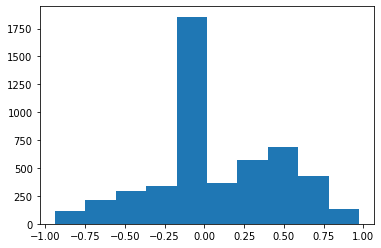

In [58]:
plt.hist(tweets['vader_compound'])

In [59]:
tweets['location'].value_counts(normalize=False, sort=True, ascending=False, bins=None, dropna=True)
#pd.value_counts(tweets['location'].values, sort=True)

                        1302
Astroworld               110
United States             79
Lagos, Nigeria            61
I Make MONEY Moves        58
                        ... 
University of zambia       1
fife                       1
Non-Ya-Biz                 1
Corvallis, OR              1
Above the clouds           1
Name: location, Length: 1810, dtype: int64

In [64]:
#correct spelling
#tweets['text'] = [i.correct() for i in tweets.text]
TextBlob(tweets.text[1]).correct()  #NNNOOOO-should not correct spelling; it destroys the original meaning

TextBlob("when twitter was champagne pope kuseimaametwe misha jeojina hobby shaggy quart elba cards b hanna now ne")

In [78]:
stop_words = set(stopwords.words('english'))

In [83]:
stop_words = set(stopwords.words('english')) 
tweets['text_no_stop'] = tweets['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [85]:
tweets.head()

,user,location,coordinates,text,sentiment,vader_sentiment,vader_compound,final_senti_score,text_no_stop
0,hits923atl,,None,dj khaled feat cardi b amp savage wish wish clean,0.366667,"{'neg': 0.186, 'neu': 0.311, 'pos': 0.503, 'compound': 0.6249}",0.6249,positive,dj khaled feat cardi b amp savage wish wish clean
1,AfahyeJ,Ghana,None,when twitter was champagne pope kuseimaametwe aisha jeojina kobby shaggy quarm ella cardi b rihanna now ne,0.000000,"{'neg': 0.0, 'neu': 0.872, 'pos': 0.128, 'compound': 0.296}",0.2960,positive,twitter champagne pope kuseimaametwe aisha jeojina kobby shaggy quarm ella cardi b rihanna ne
2,Tambae,Randburg,None,best collabo ari lennox shea butter baby ft j cole beyonc brown skin girl ft saint jhn wizkid amp bic ca,1.000000,"{'neg': 0.0, 'neu': 0.819, 'pos': 0.181, 'compound': 0.6369}",0.6369,positive,best collabo ari lennox shea butter baby ft j cole beyonc brown skin girl ft saint jhn wizkid amp bic ca
3,JAMZ4031,,None,bruno mars ft cardi b finesse remix clean,0.366667,"{'neg': 0.0, 'neu': 0.69, 'pos': 0.31, 'compound': 0.4019}",0.4019,positive,bruno mars ft cardi b finesse remix clean
4,mehjabinshahed,Bangladesh,None,when cardi b said it s gonna hurt me to hate you but loving you is worse that hit me,-0.200000,"{'neg': 0.31, 'neu': 0.499, 'pos': 0.191, 'compound': -0.3291}",-0.3291,negative,cardi b said gonna hurt hate loving worse hit


In [86]:
cv = CountVectorizer()
word_count_vector = cv.fit_transform(tweets['text_no_stop'])

In [87]:
word_count_vector.shape

(5000, 6366)

In [92]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [93]:
# print idf values
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"])
 
# sort ascending
df_idf.sort_values(by=['idf_weights'])

,idf_weights
cardi,1.130764
amp,3.084453
like,3.185891
ft,3.414835
feat,3.579857
nowplaying,3.721335
playing,3.915274
clean,3.930145
listen,3.960565
nicki,3.976130


In [95]:
# count matrix
count_vector=cv.transform(tweets['text_no_stop'])
 
# tf-idf scores
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [96]:
feature_names = cv.get_feature_names()
 
#get tfidf vector for first document
first_document_vector=tf_idf_vector[0]
 
#print the scores
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
wish,0.697266
khaled,0.348633
savage,0.345531
dj,0.294724
clean,0.271243
feat,0.247067
amp,0.212876
cardi,0.078041
picachu,0.000000
pic,0.000000


In [97]:
# OR JUST DO THIS

In [98]:
# settings that you use for count vectorizer will go here
tfidf_vectorizer=TfidfVectorizer(use_idf=True)
 
# just send in all your docs here
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(tweets['text_no_stop'])

In [99]:
# get the first vector out (for the first document)
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0]
 
# place tf-idf values in a pandas data frame
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
wish,0.697266
khaled,0.348633
savage,0.345531
dj,0.294724
clean,0.271243
feat,0.247067
amp,0.212876
cardi,0.078041
picachu,0.000000
pic,0.000000


In [109]:
lemmatizer = WordNetLemmatizer()
#not necessary to lemmetize